# ECG Split 1D-CNN Client Side

This code is the client part of ECG split 1D-CNN model for a **single** client and a server.

## Import required packages

In [9]:
from typing import List
import os
import struct
import socket
import pickle
import time
from pathlib import Path
from icecream import ic

import h5py
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD

import tenseal as ts
from tenseal.enc_context import Context
from tenseal.tensors.ckksvector import CKKSVector
from tenseal.tensors.ckkstensor import CKKSTensor
from tenseal.tensors.plaintensor import PlainTensor

print(f'torch version: {torch.__version__}')
print(f'tenseal version: {ts.__version__}')

project_path = Path.cwd().parent.parent
print(f'project_path: {project_path}')

torch version: 1.8.1+cu102
tenseal version: 0.3.5


## Socket initialization

In [11]:
host = 'localhost'
port = 10080
max_recv = 4096
s = socket.socket()
s.connect((host, port))

### Functions to send and receive messages through sockets

In [12]:
def send_msg(sock, msg):
    # prefix each message with a 4-byte length in network byte order
    msg = struct.pack('>I', len(msg)) + msg
    sock.sendall(msg)

def recv_msg(sock):
    # read message length and unpack it into an integer
    raw_msglen = recvall(sock, 4)
    if not raw_msglen:
        return None
    msglen = struct.unpack('>I', raw_msglen)[0]
    # read the message data
    return recvall(sock, msglen)

def recvall(sock, n):
    # helper function to receive n bytes or return None if EOF is hit
    data = b''
    while len(data) < n:
        packet = sock.recv(n - len(data))
        if not packet:
            return None
        data += packet
    return data

## Define ECG dataset class

In [3]:
# paths to files and directories
data_dir = 'data'  # used to be 'mitdb'
train_name = 'train_ecg.hdf5'
test_name = 'test_ecg.hdf5'

In [4]:
class ECG(Dataset):
    def __init__(self, train=True):
        if train:
            with h5py.File(project_path/data_dir/train_name, 'r') as hdf:
                self.x = hdf['x_train'][:]
                self.y = hdf['y_train'][:]
        else:
            with h5py.File(project_path/data_dir/test_name, 'r') as hdf:
                self.x = hdf['x_test'][:]
                self.y = hdf['y_test'][:]
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return torch.tensor(self.x[idx], dtype=torch.float), torch.tensor(self.y[idx])

### Set batch size

In [5]:
dry_run = True # break after 2 batches for 2 epoch, set batch size to be 2
if dry_run:
    batch_size = 2
    epoch = 2
else:
    batch_size = 32
    epoch = 400

## Make train and test dataset batch generator

In [6]:
train_dataset = ECG(train=True)
test_dataset = ECG(train=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [8]:
len(train_dataset)

13245

In [7]:
for i, b in enumerate(train_loader):
    ic(b[0].shape, b[1])
    if i == 1: break

ic| b[0].shape: torch.Size([2, 1, 128]), b[1]: tensor([2, 4])
ic| b[0].shape: torch.Size([2, 1, 128]), b[1]: tensor([2, 4])


### Total number of batches

In [35]:
total_batch = len(train_loader)
print(f'total_batch: {total_batch}')

total_batch: 6623


## Making TenSeal context

The client makes the context to homomorphically encrypt and decrypt the data

In [9]:
def context(poly_modulus_degree: int, 
            coeff_mod_bit_sizes: List[int], 
            glob_scale: int) -> Context:
    context = ts.context(
        ts.SCHEME_TYPE.CKKS, 
        poly_modulus_degree=poly_modulus_degree, 
        coeff_mod_bit_sizes=coeff_mod_bit_sizes
    )
    context.global_scale = glob_scale
    # context.generate_galois_keys()
    return context

context = context(4096, [40, 20, 40], pow(2, 20))

In [10]:
ic(context.has_galois_keys())
ic(context.has_secret_key())
ic(context.has_relin_keys())

ic| context.has_galois_keys(): False
ic| context.has_secret_key(): True
ic| context.has_relin_keys(): True


True

## Define ECG client model
Client side has only **2 convolutional layers**.

In [11]:
class EcgClient(nn.Module):
    # will be sent to the client
    def __init__(self, context: Context):
        super(EcgClient, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, 7, padding=3)  # 128 x 16
        self.relu1 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool1d(2)  # 64 x 16
        self.conv2 = nn.Conv1d(16, 16, 5, padding=2)  # 64 x 16
        self.relu2 = nn.LeakyReLU()
        self.pool2 = nn.MaxPool1d(2)  # 32 x 16
        
        self.load_init_weights()
        self.context = context
    
    def forward(self, x: torch.Tensor) -> CKKSTensor:
        x = self.conv1(x)  # [batch_size, 16, 128]
        x = self.relu1(x)
        x = self.pool1(x)  # [batch_size, 16, 64]
        x = self.conv2(x)  # [batch_size, 16, 64]
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(-1, 32 * 16)  # [batch_size, 16, 32]
        enc_x: CKKSTensor = ts.ckks_tensor(self.context, x.tolist())  # [batch_size, 512]
        return enc_x
    
    def load_init_weights(self):
        checkpoint = torch.load("init_weight.pth")
        self.conv1.weight.data = checkpoint["conv1.weight"]
        self.conv1.bias.data = checkpoint["conv1.bias"]
        self.conv2.weight.data = checkpoint["conv2.weight"]
        self.conv2.bias.data = checkpoint["conv2.bias"]

    def backward(self):
        """ 
        Calculates the gradients
        """
        raise NotImplementedError

    def update_params(self):
        """
        Update the parameters based on the gradients calculated in backward()
        """
        raise NotImplementedError

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'device: {torch.cuda.get_device_name(0)}')
ecg_client = EcgClient(context=context)
ecg_client.to(device)

device: NVIDIA GeForce GTX 1070 Ti


EcgClient(
  (conv1): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=(3,))
  (relu1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu2): LeakyReLU(negative_slope=0.01)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

## Training process

Send the `batch_size`, `total_batch`, and the `epoch` to the server

In [13]:

msg = {'batch_size': batch_size,
       'total_batch': total_batch,
       'epoch': epoch}
send_msg(sock=s, msg=pickle.dumps(msg))

NameError: name 'total_batch' is not defined

### Set random seed

In [16]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

### Set some parameters

In [30]:
criterion = nn.CrossEntropyLoss()
lr = 0.001
# we will define our own update_params() function
# optimizer = Adam(ecg_client.parameters(), lr=lr)

### Training and testing loop (client)

In [37]:
train_losses = list()
train_accs = list()
test_losses = list()
test_accs = list()
best_test_acc = 0  # best test accuracy

for e in range(epoch):
    print("Epoch {} - ".format(e+1), end='')
    
    # training loop
    for i, batch in enumerate(train_loader):
        x, y_gt = batch  # get the input data and ground-truth output in the batch
        x, y_gt = x.to(device), y_gt.to(device)  # put to cuda or cpu
        enc_activ: CKKSTensor = ecg_client(x)  # [batch_size, 512]
        enc_activ_bytes: bytes = enc_activ.serialize()  # converting into a byte tream
        # the client sends the encrypted activation maps to the server
        send_msg(sock=s, msg=enc_activ_bytes)


Epoch 1 - 

In [ ]:
print('Finished Training!')
print('Result is on the server side.')

Finished Training!
Result is on the server side.


## Experimentations

In [ ]:
x = torch.tensor([[1,2], [3,4]], requires_grad=True, dtype=torch.float32)
y = 2*x
y.retain_grad()
a = y.mean()

ic(x,y,a)

ic| x: tensor([[1., 2.],
               [3., 4.]], requires_grad=True)
    y: tensor([[2., 4.],
               [6., 8.]], grad_fn=<MulBackward0>)
    a: tensor(5., grad_fn=<MeanBackward0>)


(tensor([[1., 2.],
         [3., 4.]], requires_grad=True),
 tensor([[2., 4.],
         [6., 8.]], grad_fn=<MulBackward0>),
 tensor(5., grad_fn=<MeanBackward0>))

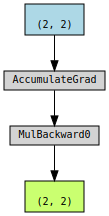

In [ ]:
from torchviz import make_dot
make_dot(y)

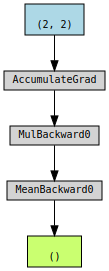

In [ ]:
make_dot(a)

In [ ]:
a.backward()

In [ ]:
ic(y.grad)

ic| y.grad: tensor([[0.2500, 0.2500],
                    [0.2500, 0.2500]])


tensor([[0.2500, 0.2500],
        [0.2500, 0.2500]])

In [ ]:
ic(x.grad)

ic| x.grad: tensor([[0.5000, 0.5000],
                    [0.5000, 0.5000]])


tensor([[0.5000, 0.5000],
        [0.5000, 0.5000]])

In [ ]:
a2 = a.clone().detach().requires_grad_(True)
pickle.dumps(a2)

b'\x80\x04\x95}\x01\x00\x00\x00\x00\x00\x00\x8c\x0ctorch._utils\x94\x8c\x12_rebuild_tensor_v2\x94\x93\x94(\x8c\rtorch.storage\x94\x8c\x10_load_from_bytes\x94\x93\x94C\xff\x80\x02\x8a\nl\xfc\x9cF\xf9 j\xa8P\x19.\x80\x02M\xe9\x03.\x80\x02}q\x00(X\x10\x00\x00\x00protocol_versionq\x01M\xe9\x03X\r\x00\x00\x00little_endianq\x02\x88X\n\x00\x00\x00type_sizesq\x03}q\x04(X\x05\x00\x00\x00shortq\x05K\x02X\x03\x00\x00\x00intq\x06K\x04X\x04\x00\x00\x00longq\x07K\x04uu.\x80\x02(X\x07\x00\x00\x00storageq\x00ctorch\nFloatStorage\nq\x01X\x0e\x00\x00\x0094019819879440q\x02X\x03\x00\x00\x00cpuq\x03K\x01Ntq\x04Q.\x80\x02]q\x00X\x0e\x00\x00\x0094019819879440q\x01a.\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\xa0@\x94\x85\x94R\x94K\x00))\x88\x8c\x0bcollections\x94\x8c\x0bOrderedDict\x94\x93\x94)R\x94t\x94R\x94.'